## Set up

In [1]:
import pickle
from copy import deepcopy
import pandas as pd
import numpy as np
from osgeo.gdalconst import *
from osgeo import gdal
from scipy.ndimage import gaussian_filter, median_filter
#visualization
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
#import custom functions
from custom_functions import *

### Load demo data

In [34]:
def process_data(path_csv, path_raws, nrcan_name = 'land_cover.tif', index = [0, 3], 
                 target_outlier = False, gaussian = False, clustering = False, calculate_layers = False):
    if path_csv is not None:
        #get y from csv and reshape
        raw = pd.read_csv(path_csv)
        raw.land_cover = raw.land_cover.astype('int')
        y_demo = raw['land_cover']
        #reshape to use y_demo with gaussian X
        y_demo = y_demo.values.reshape(2500, 2100).T
        y_demo = y_demo.flatten()
        
         #get X from gdal function
        raw = gdal_to_dataframe(path_raws, nrcan_name = nrcan_name, index = index)
        X_demo = raw.drop('y', axis = 1)
    else:
        #get X from gdal function
        raw = gdal_to_dataframe(path_raws, nrcan_name = nrcan_name, index = index)
        y_demo = raw.y
        X_demo = raw.drop('y', axis = 1)
    

    #X_demo = X_demo[['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11','B12', 'B8A']]

    if target_outlier is not False:
        if target_outlier[0] == 'B':
            X_demo[target_outlier] = outlier_fix(X_demo)[target_outlier]
        else:
            X_demo = outlier_fix(X_demo)
    
    if gaussian == True:
        #reset demo raw for matching filtering
        raw = gdal_to_dataframe(path_raws, nrcan_name = nrcan_name, index = index)
        #demo_raw = outlier_fix(demo_raw)
        #filter raws from path
        gauss_demo = filter_raws(path_raws, nrcan_name = nrcan_name, index = index)

        #concat gauss and raw
        gauss_demo_reset = gauss_demo.drop('y', axis = 1)
        #rename gauss columns
        gauss_names = [f'{name}g' for name in gauss_demo_reset.columns]
        gauss_demo_reset.columns = gauss_names
        #reset indices
        raw.reset_index(inplace=True, drop=True)
        gauss_demo_reset.reset_index(inplace=True, drop=True)    
        merged_df = pd.concat([raw, gauss_demo_reset], axis = 1)

        #select X values from gaussian dataframe
        X_demo = merged_df.drop('y', axis = 1)

        #X_demo = X_demo[['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11',
       #'B12', 'B8A', 'B01g', 'B02g', 'B03g', 'B04g', 'B05g', 'B06g', 'B07g', 'B08g', 'B09g', 'B11g', 'B12g', 'B8Ag']]
        
    if clustering is not False:
        param = pickle.load(open(clustering, 'rb'))
        demo_cluster = param.predict(X_demo.astype('double'))
        X_demo['clusters'] = demo_cluster
        
    if calculate_layers is not False:
        X_demo = add_layers(X_demo)
        X_demo = replace_values(X_demo)
        
        if calculate_layers == 'Extra':
            X_demo = add_extra_layers(X_demo)
        
    return X_demo, y_demo
    
    
X_test, y_test = process_data('../data_tests/demo_site.csv', '../data_tests/demo/raws', calculate_layers = 'Extra') 
X_test.columns

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11',
       'B12', 'B8A', 'NDVI', 'Moisture', 'NDWI', 'NDSI', 'NIRB', 'ARG',
       'yellow', 'MIVI', 'GDVI'],
      dtype='object')

## Combine Forests with different features

Versions:
- 10_bin14_13: base of version 10 with add on forest_bin14 for class 14 and taking 15 and 17 from version 13 in that order
    - demo accuracy 52.40 (b: 41.22%)
- 10_xgbin14_13: base of version 10 with add on xgb_bin14 for class 14 and taking 15 and 17 from version 13 in that order
    - demo accuracy 52.45 (b: 41.35%)

In [4]:
#load in models
forest_10 = pickle.load(open('models/forest_10.sav', 'rb'))
forest_13 = pickle.load(open('models/forest_13.sav', 'rb'))
forest_bin14 = pickle.load(open('models/forest_bin14.sav', 'rb'))
xgb_bin14 = pickle.load(open('models/xgb_bin14.sav', 'rb'))

In [101]:
def predict_combo(base_model, add_model, path_csv, path_raws, index = [0, 3], class_lists = [[14], [15, 17]], nrcan_name = 'land_cover.tif'):
    
    #process data for each model
    base_X, base_y = process_data(path_csv, path_raws, index = index, target_outlier = 'B01f', calculate_layers = True, nrcan_name = nrcan_name)
    add_X_1, _ = process_data(path_csv, path_raws, index = index, calculate_layers = 'Extra', nrcan_name = nrcan_name)
    add_X_2, _ = process_data(path_csv, path_raws, index = index, gaussian = True, clustering = '../models/kcluster_13.sav', calculate_layers = True, nrcan_name = nrcan_name)
    
    #predict with each model
    base_pred = pd.DataFrame(base_model.predict(base_X))
    add_pred_1 = pd.DataFrame(add_model[0].predict(add_X_1))
    add_pred_2 = pd.DataFrame(add_model[1].predict(add_X_2))
    
    add_pred_1 = add_pred_1.replace(1, 14)
    
    #select only classes in list from additional forest
    add_1_subset = add_pred_1[add_pred_1[0].isin(class_lists[0]) ]
    add_2_subset = add_pred_2[add_pred_2[0].isin(class_lists[1]) ]
    
    #updat base_pred with subset
    base_pred.update(add_1_subset)
    base_pred.update(add_2_subset)
    #convert to int
    base_pred = base_pred.astype('int')
    
    return base_pred, base_y


### Demo test

In [102]:
combo_pred, y_true = predict_combo(forest_10, [xgb_bin14, forest_13], '../data_tests/demo_site.csv',  '../data_tests/demo/raws')

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, balanced_accuracy_score

C:\Users\fynn\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.4135638683149377
0.525448


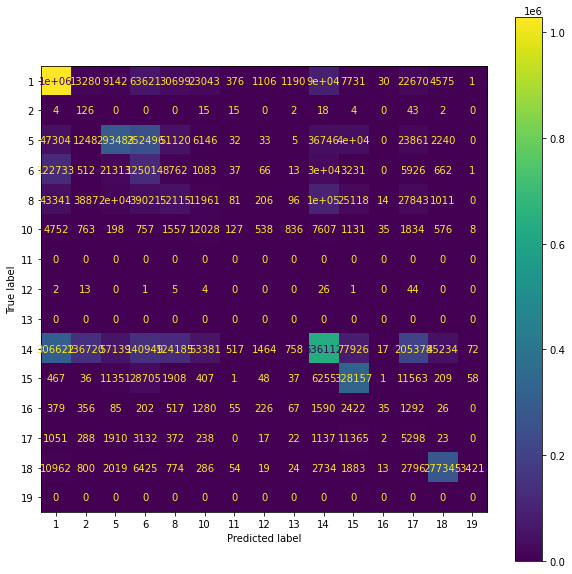

In [103]:
#accuracy
print(balanced_accuracy_score(y_true, combo_pred))
print(accuracy_score(y_true, combo_pred))

#confusion matrix
cm_forest = confusion_matrix(y_test, combo_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest, display_labels = forest_10.classes_)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

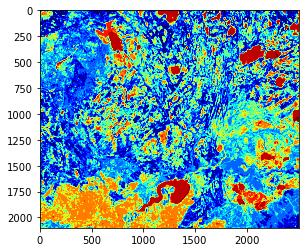

In [104]:
map_pred = np.asarray(combo_pred.values).reshape(2100, 2500)
cmap = cm.get_cmap('jet', 19)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

In [105]:
#OPTIONAL: save matrix and map as versions
#save confusion matrix
cm_forest_fig.figure_.savefig(os.path.join('evaluation', 'demo/combo', '10_xgbin14_13_cm.png'))

#save prediction map
prediction_map.figure.savefig(os.path.join('evaluation', 'demo/combo', '10_xgbin14_13_map.png'))

In [95]:
print(classification_report(y_true, combo_pred, zero_division = 0))

              precision    recall  f1-score   support

           1       0.44      0.18      0.25     50155
           2       0.00      0.00      0.00         0
           5       0.56      0.57      0.56    221241
           6       0.58      0.64      0.61    271199
           8       0.04      0.01      0.02      5414
          10       0.03      0.01      0.01      1855
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.10      0.51      0.17      7515
          15       0.84      0.72      0.77    153148
          16       0.06      0.00      0.00      5168
          17       0.53      0.60      0.56     44434
          18       0.94      0.82      0.88     59871
          19       0.00      0.00      0.00         0

    accuracy                           0.61    820000
   macro avg       0.27      0.27      0.26    820000
weighted avg       0.63   

### Random extent test

In [88]:
X_ran, y_ran = process_data(None, '../data_tests/trois/raws', nrcan_name = 'NRCAN_transformed.tif', index = [-14, -11], gaussian = True, clustering = 'models/kcluster_13.sav', calculate_layers = True)
X_ran, y_ran = process_data(None, '../data_tests/trois/raws', nrcan_name = 'NRCAN_transformed.tif', index = [-14, -11], target_outlier = 'B01f', calculate_layers = True)

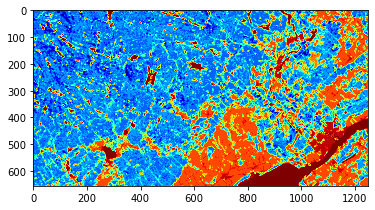

In [77]:
map_pred = np.asarray(y_ran.values).reshape(656, 1250)
cmap = cm.get_cmap('jet', 19)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

#### Combination

In [78]:
combo_pred, y_true = predict_combo(forest_10, [xgb_bin14, forest_13], None, '../data_tests/trois/raws', index = [-14, -11], nrcan_name = 'NRCAN_transformed.tif')

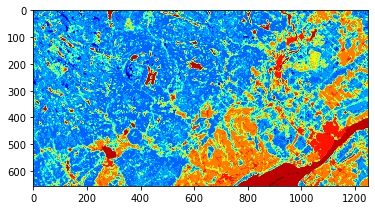

In [81]:
map_pred = np.asarray(combo_pred.values).reshape(656, 1250)
cmap = cm.get_cmap('jet', 19)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

C:\Users\fynn\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.40592682201005204
0.6087926829268293


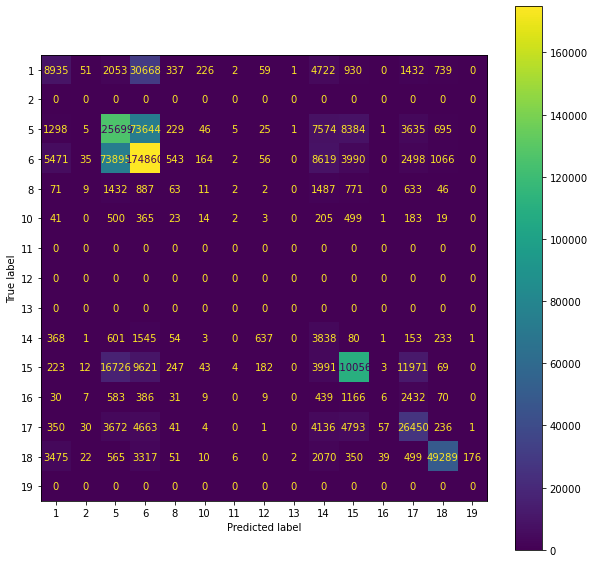

In [82]:
#accuracy
print(balanced_accuracy_score(y_true, combo_pred))
print(accuracy_score(y_true, combo_pred))

#confusion matrix
cm_forest = confusion_matrix(y_true, combo_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest, display_labels = forest_10.classes_)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

#### Forest only

In [89]:
forest_pred = forest_10.predict(X_ran)

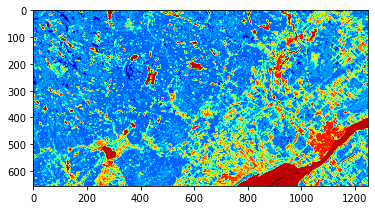

In [90]:
map_pred = np.asarray(forest_pred).reshape(656, 1250)
cmap = cm.get_cmap('jet', 19)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

C:\Users\fynn\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.33198380326445226
0.5562378048780487


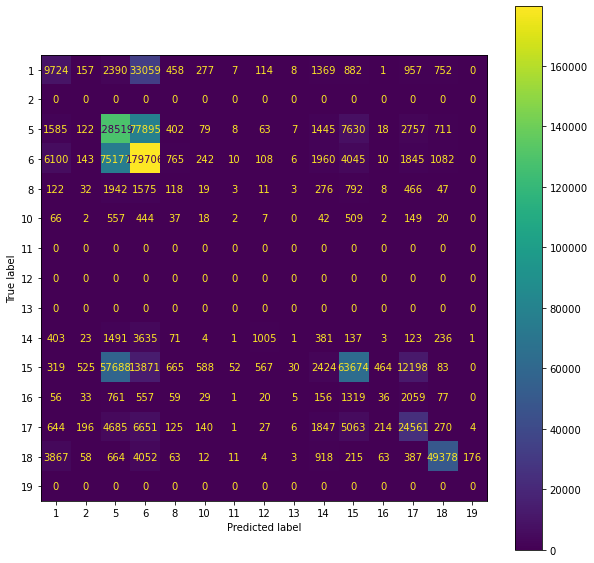

In [91]:
print(balanced_accuracy_score(y_true, forest_pred))
print(accuracy_score(y_true, forest_pred))

#confusion matrix
cm_forest = confusion_matrix(y_true, forest_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest, display_labels = forest_10.classes_)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

In [83]:
print(classification_report(y_true, combo_pred, zero_division = 1))

              precision    recall  f1-score   support

           1       0.44      0.18      0.25     50155
           2       0.00      1.00      0.00         0
           5       0.56      0.57      0.56    221241
           6       0.58      0.64      0.61    271199
           8       0.04      0.01      0.02      5414
          10       0.03      0.01      0.01      1855
          11       0.00      1.00      0.00         0
          12       0.00      1.00      0.00         0
          13       0.00      1.00      0.00         0
          14       0.10      0.51      0.17      7515
          15       0.84      0.72      0.77    153148
          16       0.06      0.00      0.00      5168
          17       0.53      0.60      0.56     44434
          18       0.94      0.82      0.88     59871
          19       0.00      1.00      0.00         0

    accuracy                           0.61    820000
   macro avg       0.27      0.60      0.26    820000
weighted avg       0.63   

In [92]:
print(classification_report(y_true, forest_pred, zero_division = 1))

              precision    recall  f1-score   support

           1       0.42      0.19      0.27     50155
           2       0.00      1.00      0.00         0
           5       0.47      0.58      0.52    221241
           6       0.56      0.66      0.61    271199
           8       0.04      0.02      0.03      5414
          10       0.01      0.01      0.01      1855
          11       0.00      1.00      0.00         0
          12       0.00      1.00      0.00         0
          13       0.00      1.00      0.00         0
          14       0.04      0.05      0.04      7515
          15       0.76      0.42      0.54    153148
          16       0.04      0.01      0.01      5168
          17       0.54      0.55      0.55     44434
          18       0.94      0.82      0.88     59871
          19       0.00      1.00      0.00         0

    accuracy                           0.56    820000
   macro avg       0.25      0.55      0.23    820000
weighted avg       0.58   

## Combine seperate models

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier